
# COVID-Team-1
### Dr. Mohanty
### Christopher Brantley
### CSC 405 01
### Last Updated: 10/27/2020
### I, Christopher Brantley, have abided by the UNCG academic policy.

In [1]:
# Changing directory so we can import covid_data.
import os 
os.chdir("../")

## Imports.

In [2]:
import ipynb
from ipynb.fs.full import covid_data as cd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Pandas Display Options.

In [3]:
# Telling pandas not convert to html tags.
pd.set_option('display.html.table_schema', True)
# Max columns and rows to display.
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 8)

### Data Paths

In [4]:
# Relative to "../"
_state_daily_cases = "./chris/DATA/state_county_daily_cases.csv"
_state_daily_deaths = "./chris/DATA/state_county_daily_deaths.csv"

_state_weekly_casees = "./chris/DATA/state_county_weekly_cases.csv"
_state_weekly_deaths = "./chris/DATA/state_county_weekly_deaths.csv"

_state_county_weekly_stats_cases = "./chris/DATA/state_county_weekly_stats_cases.csv"
_state_county_weekly_stats_deaths = "./chris/DATA/state_county_weekly_stats_deaths.csv"

# Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state.


### Generating daily new cases for State by county.

In [5]:
# Gets the daily new cases for any state and exports to csv.
def state_daily_cases_to_csv(_state):
    df_primary_data = cd.get_covid_primary_data()
    # Get all columns that have County or cases.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Setting index as county name.
    df_state_cases.set_index("County Name", inplace = True)
    # Creating new dataframe with county names as index.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Getting number of days by getting number of columns that contain cases keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    #  We iterate from the end so we will utilize negative values here.
    for day in range(-1, -number_days, -1):
        # Get the column name of day of cases.
        column_name = df_state_cases.columns[day]
        # Get the current case values and subtract the previous days.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert into dataframe the day of cases and the number of new cases.
        df_daily_cases.insert(0, column_name, column_value)
    # Because the first day has no preceding cases we will insert these as is.
    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    # We will export the data.
    df_daily_cases.to_csv(_state_daily_cases)

### Generating daily new deaths for State by county.

In [6]:
# Gets the daily new deaths and exports to csv.
def state_daily_deaths_to_csv(state):
    # First get our primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Find any columns that are containing keywords county/deaths.
    df_state_deaths = df_primary_data[df_primary_data.State == state].filter(regex = "County|deaths")
    # Setting county name as the index.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe to hold daily new deaths, with index of counties.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get number of recorded days by the number of columns that exist.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # We start at the end and move to the front of data so we utilize negative values.
    for day in range(-1, - number_days, -1):
        # Get the current column name for date value.
        column_name = df_state_deaths.columns[day]
        # Get the current daily death value and subtract the previous daily death value.
        # This yields daily new death value.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert the daily death column/value into the dataframe.
        df_daily_deaths.insert(0, column_name, column_values)
    # The first value does not have a preceding day so we will just copy these values as is.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    # Export data to csv.
    df_daily_deaths.to_csv(_state_daily_deaths)

### Accessor methods for State Daily Cases and Deaths.

In [7]:
# Accessor method for state daily cases by county.
def get_state_daily_cases(_state):
    """Returns dataframe containing state daily cases by county."""
    state_daily_cases_to_csv(_state)
    return pd.read_csv(_state_daily_cases, index_col=[0])
    
# Accessor method for state daily deaths by county.
def get_state_daily_deaths(_state):
    """Returns dataframe containing state daily deaths by county."""
    state_daily_deaths_to_csv(_state)
    return pd.read_csv(_state_daily_deaths, index_col=[0])

### Accessor/Generator for Normalized Daily Cases

In [8]:
# Generates daily normalized cases.
def state_daily_cases_normalized(_state):
    # Get the covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get all columns that contain keywords County/cases.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Set the county name as index.
    df_state_cases.set_index("County Name", inplace = True)
    # Create daily cases dataframe with index of counties.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Get the relevant state population data.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set the county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get the number of days as the number of columns that contain cases as keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    # We will work in reverse, end to front of dataframe.
    for day in range(-1, -number_days, -1):
        # Get the column name for date value.
        column_name = df_state_cases.columns[day]
        # Get the current day subtracting the pror day.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert extracted date/value combo to df_daily_cases.
        df_daily_cases.insert(0, column_name, column_value)
    # We iterate over each county.
    for county in df_state_cases.index.values:
        # Get the population for current county.
        pop = df_state_pop.loc[county,"population"]
        # Swap the values out for the normalized value.
        df_daily_cases.loc[county, :] = \
        df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # We will not need to subtract the prior day from the first day so we just apply normalization.
    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].apply(lambda x: round(((x / pop) * 100000), 0)).values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    
    return df_daily_cases

In [9]:
# Generates log10 daily cases.
def state_daily_cases_log10(_state):
    # We get the primary covid data.
    df_primary_data = cd.get_covid_primary_data()
    # Get specific state and all columns that contain keywords.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Set index as county names.
    df_state_cases.set_index("County Name", inplace = True)
    # Crate new dataframe to hold daily cases, index is counties.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Get the relevant county populations.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get number days as number of columns that contain keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    # Start at the end and work towards the front of dataframe.
    for day in range(-1, -number_days, -1):
        # Get the current column name for date info.
        column_name = df_state_cases.columns[day]
        # Get the current daily value subtracting the prior daily value.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert the extracted info into our daily dataframe.
        df_daily_cases.insert(0, column_name, column_value)
    # For each county we...
    for county in df_state_cases.index.values:
        # Get the county population.
        pop = df_state_pop.loc[county,"population"]
        # We normalize and then take get log10 value.
        df_daily_cases.loc[county, :] = \
        np.log10(df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)
    # No prior day exists for the first date so we just normalize and calculate log10 value.
    first_column_name = df_state_cases.columns[0]
    first_column_values = np.log10(df_state_cases.iloc[:, 0:1]\
                                   .apply(lambda x: round(((x / pop) * 100000), 0)).values)
    df_daily_cases.insert(0, first_column_name, first_column_values)
    
    return df_daily_cases

### Accessor/Generator for Normalized Daily Deaths

In [10]:
# Generates normalized daily deaths.
def state_daily_deaths_normalized(_state):
    # Get covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get columns that match keywords County/deaths.
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    # Set index as county names.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe with index as county names.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get state specific population information.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set state pop index as county name.
    df_state_pop.set_index("County Name", inplace = True)
    # Calculate number days as number of columns that contain death keyword.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # Work from the back of dataframe towards the front.
    for day in range(-1, - number_days, -1):
        # Extract the current date value.
        column_name = df_state_deaths.columns[day]
        # Get the current value and subtract the prior daily value.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert information into the daily dataframe.
        df_daily_deaths.insert(0, column_name, column_values)
    # For each county.
    for county in df_daily_deaths.index.values:
        # Get the county's population.
        pop = df_state_pop.loc[county,"population"]
        # Apply normalization to each county by respective population.
        df_daily_deaths.loc[county, :] = \
        df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Normalize and insert first row of data, no prior date exists to calculate daily value.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

In [11]:
# Gnerates log10 daily deaths.
def state_daily_deaths_log10(_state):
    # Get primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Retrieve all columns containing keywords.
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    # Set index as county names.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe to hold daily deaths with county names as index.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get the state specific population information.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set index as county name.
    df_state_pop.set_index("County Name", inplace = True)
    # Let number days equal the length of the columns that contain deaths as keyword.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # Work from back to front of database.
    for day in range(-1, - number_days, -1):
        # Get the current date value.
        column_name = df_state_deaths.columns[day]
        # Get the daily deaths, current day - prior day.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert extracted information as daily deaths.
        df_daily_deaths.insert(0, column_name, column_values)
    # For each county in df_daily_deaths.
    for county in df_daily_deaths.index.values:
        # Get county population.
        pop = df_state_pop.loc[county,"population"]
        # Apply population normalization and apply log10.
        df_daily_deaths.loc[county, :] = \
        np.log10(df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)
    # Apply normalization and log10 to first date value.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = np.log10(df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values)
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

### Generating Weekly Cases for State by County.

In [12]:
# Generates weekly new cases.
def state_weekly_cases_to_csv(state):
    # Get daily cases.
    df_county_cases = get_state_daily_cases(state)
    # Get shape of dataframe where all columns contain cases as keyword as number days.
    number_days = df_county_cases.filter(regex = "cases").shape[1]
    # We will get the number of days needed to make number_days divisible by 7 to calculate number of weeks.
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)

    index_county = []
    index_weeks = []
    # Create each week for each county for multi index purposes.
    for county in df_county_cases.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
    # Create new dataframe with multi index and columns as cases.
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],\
                                   columns = ["cases"])
    # For each county.
    for county in df_county_cases.index.values:
        # For each increment of seven columns.
        for column in range(0, df_county_cases.shape[1], 7):
            # Find the weekly sum and assign it to proper index.
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_cases.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_casees)

### Generating Weekly Deaths for State by County.

In [13]:
# Generates weekly new deaths.
def state_weekly_deaths_to_csv(state):
    # Get state daily deaths.
    df_county_deaths = get_state_daily_deaths(state)
    # Get number of columns that contain keyword deaths.
    number_days = df_county_deaths.filter(regex = "deaths").shape[1]
    # Make number_days divisible by seven and calculate number of weeks.
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)
    
    index_county = []
    index_weeks = []
    # Create multi index of each week for each county.
    for county in df_county_deaths.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
    # Create dataframe with multi index and columns as deaths.
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],
                                    columns = ["deaths"])
    # For each county.
    for county in df_county_deaths.index.values:
        # For each seven daily deaths.
        for column in range(0, df_county_deaths.shape[1], 7):
            # Calculate the sum and store it in proper index of weekly deaths.
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_deaths.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [14]:
# Accessor method for state weekly cases by county.
def get_state_weekly_cases(_state):
    state_weekly_cases_to_csv(_state)
    # index_col is necessary to show that 0, 1 make up a multiindex.
    return pd.read_csv(_state_weekly_casees, index_col=[0, 1])
    
# Accessor method for state weekly deaths by county.
def get_state_weekly_deaths(_state):
    state_weekly_deaths_to_csv(_state)
    # index_col is necessary to show that 0, 1 make up a multiindex.
    return pd.read_csv(_state_weekly_deaths, index_col=[0, 1])

### Generating Weekly Case Stats for State by county.

In [15]:
# Generates weekly stats for state cases.
def state_weekly_cases_stats_to_csv(_state,):
    # Get primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get columns that contain county/population for specific state.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get weekly case values.
    df_weekly_normalized = get_state_weekly_cases(_state)

    # Normalizing weekly cases to 100,000.
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Get the county's population.
        pop = df_state_pop.loc[county, "population"]
        # Normalize and round so that mode can be calculated.
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Create new dataframe with county names as index, columns as statistical measurements.
    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Calculate statistical measurements.
        df_county_normalized.loc[county, "mean"] = df_weekly_normalized.loc[county].mean()[0]
        df_county_normalized.loc[county, "median"] = df_weekly_normalized.loc[county].median()[0]
        df_county_normalized.loc[county, "mode"] = df_weekly_normalized.loc[county].mode().values[0,0]
    df_county_normalized.to_csv(_state_county_weekly_stats_cases)

### Generating Weekly Deaths Stats for State by county.

In [16]:
# Generates weekly stats for state deaths.
def state_weekly_deaths_stats_to_csv(_state,):
    # Get covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get state specific data where columns match County and population keywords.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set index as county names.
    df_state_pop.set_index("County Name", inplace = True)
    # Get weekly deaths.
    df_weekly_normalized = get_state_weekly_deaths(_state)

    # Normalizing deaths to 100,000.
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Get county's population.
        pop = df_state_pop.loc[county, "population"]
        # Normalize weekly data.
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Create new dataframe with county names as index, columns as statistical measurements.
    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Calculate statistical measurements.
        df_county_normalized.loc[county, "mean"] = round(df_weekly_normalized.loc[county].mean()[0], 0)
        df_county_normalized.loc[county, "median"] = round(df_weekly_normalized.loc[county].median()[0])
        df_county_normalized.loc[county, "mode"] = round(df_weekly_normalized.loc[county].mode().values[0,0], 0)
    df_county_normalized.to_csv(_state_county_weekly_stats_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [17]:
# Accessor method for state weekly cases by county.
def get_county_weekly_cases_stats(_state):
    state_weekly_cases_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_cases, index_col=[0])
    
# Accessor method for state weekly deaths by county.
def get_county_weekly_deaths_stats(_state):
    state_weekly_deaths_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_deaths, index_col=[0])

### Generator and Accessor for  Weekly Cases Stats for State.

In [18]:
# Generates county overall statistical measurements for both cases/deaths.
def county_weekly_stats_overall(_state):
    # Create dataframe to hold states weekly cases/deaths as index, statistical measurements as columns.
    df_overall_weekly_county = pd.DataFrame(index = [_state + " weekly cases",
                                 _state + " weekly deaths"],
                 columns = ["mean", "median", "mode"])
    # For each case/death, weekly case stats, weekly death stats get overall statistical measurement.
    for data_type, dataset in zip(tuple(df_overall_weekly_county.index.values),\
                                  (get_county_weekly_cases_stats(_state),\
                                   get_county_weekly_deaths_stats(_state))):
        # Calculating overall statistical measurements.
        df_overall_weekly_county.loc[data_type, "mean"] = dataset["mean"].mean()
        df_overall_weekly_county.loc[data_type, "median"] = dataset["median"].median()
        df_overall_weekly_county.loc[data_type, "mode"] = dataset["mode"].mode()[0]

    return df_overall_weekly_county

# Task 1.1 Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state. 

In [19]:
display(get_county_weekly_cases_stats("FL"))

,mean,median,mode
Alachua County,72.400000,19.0,0.0
Baker County,132.371429,14.0,0.0
Bay County,93.714286,7.0,0.0
Bradford County,97.600000,14.0,0.0
...,...,...,...
Volusia County,53.142857,14.0,0.0
Wakulla County,88.542857,15.0,0.0
Walton County,71.571429,20.0,0.0
Washington County,117.971429,16.0,0.0


In [20]:
display(get_county_weekly_deaths_stats("FL"))

,mean,median,mode
Alachua County,0.0,0,0.0
Baker County,1.0,0,0.0
Bay County,2.0,0,0.0
Bradford County,1.0,0,0.0
...,...,...,...
Volusia County,1.0,1,0.0
Wakulla County,1.0,0,0.0
Walton County,1.0,0,0.0
Washington County,2.0,0,0.0


In [21]:
display(county_weekly_stats_overall("FL"))

,mean,median,mode
FL weekly cases,98.7748,18,0
FL weekly deaths,1.65672,0,0


# Task 1.2 Compare the data against other states.

#### Generating Random States

In [22]:
# Get primary data.
df_primary_data = cd.get_covid_primary_data()
# Get all data, excluding FL.
df_primary_data = df_primary_data[df_primary_data.State != "FL"]
# Generate five random states.
random_states = np.random.choice(df_primary_data.State.values, 5)
display(random_states.tolist())
# Hard coding states for consistency.
random_states = ['ND', 'IL', 'NM', 'ID', 'TX']

['MO', 'NE', 'NE', 'OK', 'ND']

#### Generating Weekly Data for Each State

In [23]:
# Creating list of all states for looping possibilities.
all_states = random_states
all_states.append("FL")
# Create dataframe where index is each state, and columns are statistical measurements.
df_state_data = pd.DataFrame(index =  all_states,
                            columns = ["mean", "median", "mode"])
# For each state.
for state in all_states:
    # Calculate statistical measurement.
    df_weekly_stats = county_weekly_stats_overall(state)
    df_state_data.loc[state, "mean"] = df_weekly_stats.iloc[0]["mean"]
    df_state_data.loc[state, "median"] = df_weekly_stats.iloc[0]["median"]
    df_state_data.loc[state, "mode"] = df_weekly_stats.iloc[0]["mode"]
display(df_state_data)

,mean,median,mode
ND,42.9833,0,0
IL,39.0669,9,0
NM,29.3784,6,0
ID,42.7416,4.5,0
TX,55.4897,8,0
FL,98.7748,18,0


# Comparing Cases by County by Week per State - Normalized to Cases per 100,000

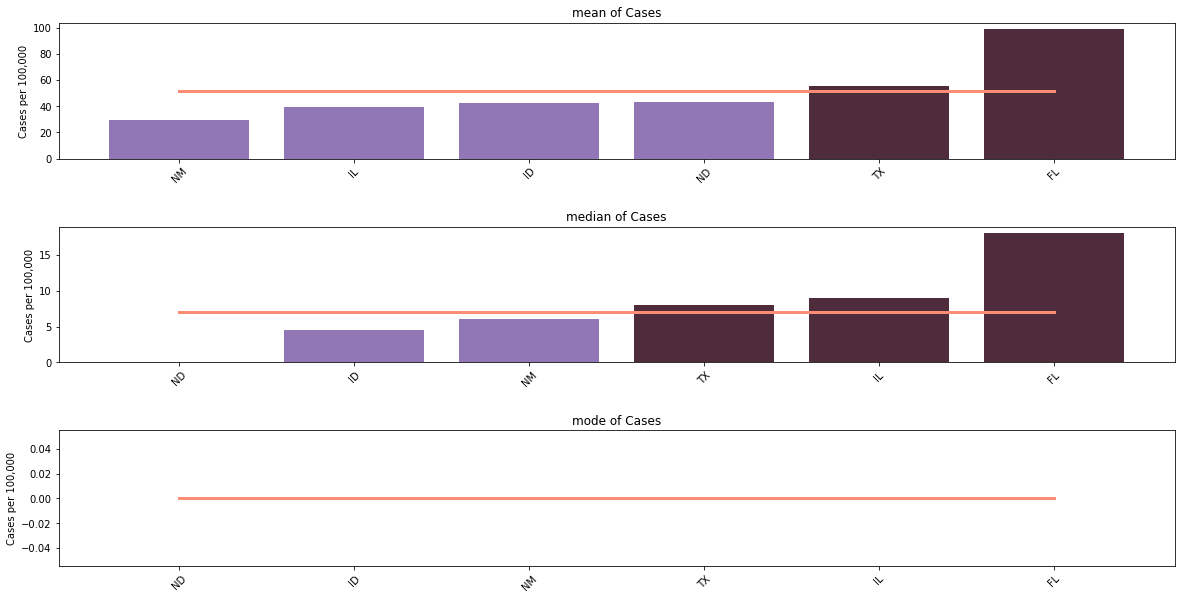

In [24]:
# Calcualte overall statistical measurements.
ov_mean = df_state_data.loc[:, "mean"].mean()
ov_median = df_state_data.loc[:, "median"].median()
ov_mode = df_state_data.loc[:, "mode"].mode()[0]
# Create subplots containing three rows.
figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
# For each row, statistical measurements, and statistical measurement values.
for row, stat_type, ov_measure in zip(range(0,3,1), ("mean", "median", "mode"), (ov_mean, ov_median, ov_mode)):
    # Sort values by statistical measurement.
    df_state_data = df_state_data.sort_values(by = stat_type, ascending = True)
    # Get the stat. values.
    y_values = df_state_data.loc[:, stat_type]
    # Plot bar graph of data.
    bars = axis[row].bar(df_state_data.index.tolist(), y_values, color =\
                        ["#4E2C3C" if data >= ov_measure else "#9177B5" for data in y_values])
    # Plot the overall stat measurement.
    axis[row].plot(df_state_data.index.values, np.full(len(df_state_data.index.values), fill_value = ov_measure),\
                  linewidth = 3, color = "#FC8C74")
    # Setting Graph Properties.
    axis[row].title.set_text(stat_type + " of Cases")
    axis[row].set_ylabel("Cases per 100,000")
    axis[row].tick_params(axis = "x", rotation = 45)
plt.show()

#### When comparing the data we can see that our average is highly affected by outliers. Florida has a much higher average than the other states that we have selected.

#### When looking at our median we see that we have a much more neutral central measurement. We have clear indication here that Florida is indeed the top performer for cases.

#### When looking at our mode we are missing values, this is most likely due to the method of measurement requiring the most repeated element. 0 is our most repeated element here due to the initial data elements showing no cases. We may want to consider methods to bring mode to life by trimming the data.

#### Generating Weekly Data for Each State

In [25]:
# Getting random states.
all_states = random_states
all_states.append("FL")
# Creating dataframe where index is the states, columns are statistical measurements.
df_state_data = pd.DataFrame(index =  all_states,
                            columns = ["mean", "median", "mode"])
# For each state.
for state in all_states:
    # Calculate statistical measurements.
    df_weekly_stats = county_weekly_stats_overall(state)
    df_state_data.loc[state, "mean"] = df_weekly_stats.iloc[1]["mean"]
    df_state_data.loc[state, "median"] = df_weekly_stats.iloc[1]["median"]
    df_state_data.loc[state, "mode"] = df_weekly_stats.iloc[1]["mode"]
display(df_state_data)

,mean,median,mode
ND,0.377358,0,0
IL,0.735294,0,0
NM,0.848485,0,0
ID,0.454545,0,0
TX,1.56299,0,0
FL,1.65672,0,0
FL,1.65672,0,0


# Comparing Deaths by County by Week per State - Normalized to Deaths per 100,000

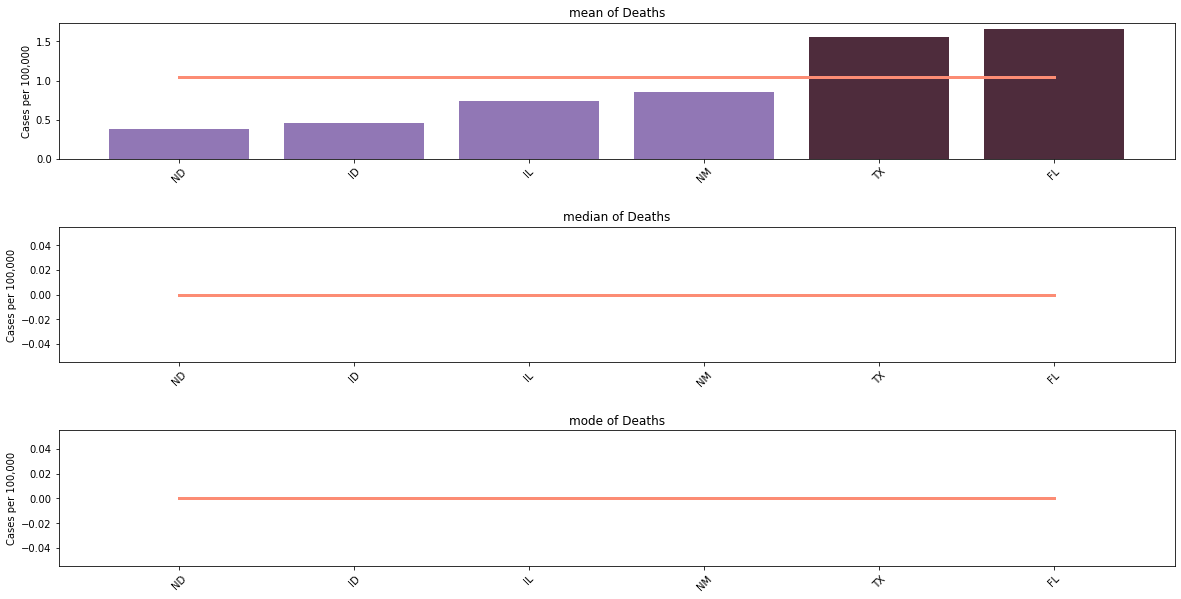

In [26]:
# Calculate the overall statistical measurements.
ov_mean = df_state_data.loc[:, "mean"].mean()
ov_median = df_state_data.loc[:, "median"].median()
ov_mode = df_state_data.loc[:, "mode"].mode()[0]
# Create subplot consisting of three rows.
figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
# For each row, measurements, values.
for row, stat_type, ov_measure in zip(range(0,3,1), ("mean", "median", "mode"), (ov_mean, ov_median, ov_mode)):
    # Sort measurements by ascending order.
    df_state_data = df_state_data.sort_values(by = stat_type, ascending = True)
    # Get the values of measurement.
    y_values = df_state_data.loc[:, stat_type]
    # Plot the bar graph.
    bars = axis[row].bar(df_state_data.index.tolist(), y_values, color =\
                        ["#4E2C3C" if data >= ov_measure else "#9177B5" for data in y_values])
    # Plot the overall statistical measurement.
    axis[row].plot(df_state_data.index.values, np.full(len(df_state_data.index.values), fill_value = ov_measure),\
                  linewidth = 3, color = "#FC8C74")
    # Setting Graph Properties
    axis[row].title.set_text(stat_type + " of Deaths")
    axis[row].set_ylabel("Cases per 100,000")
    axis[row].tick_params(axis = "x", rotation = 45)
plt.show()

#### For the average of deaths we can see that Texas and Florida are our top performers and that the graph is skewed left. Because of this we would assume the measure of center to be lower than what is shown (1).

#### For the median of deaths we can see little data to compare. This is a result of many 0 death days. There is no reason to increase normalization here, 0 is 0.

#### For the mode of deaths we see 0 for all entries. This is also indicative of many 0 death days.

# Task 1.3 Identify counties with high case and death rates. - (For Florida)

In [27]:
# Get weekly stats.
df_weekly_stats = get_county_weekly_cases_stats("FL")

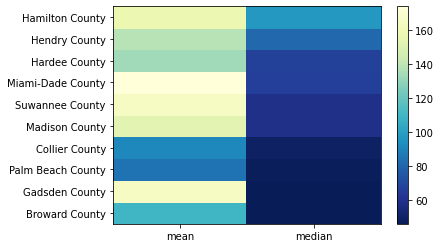

In [28]:
# Calculate threshold for top 15% of data by highest median values.
top_25_median = df_weekly_stats["median"].quantile(.85)
# Get top 15% of data by highest median values.
df_25_median = df_weekly_stats[df_weekly_stats["median"] >= top_25_median].sort_values(by = "median")
# Create subplots.
figure, h_map = plt.subplots(1,1)
# Create heat map.
cbar = h_map.pcolor(df_25_median.iloc[:,0:2], cmap='YlGnBu_r')
# Create color bar.
figure.colorbar(cbar, ax = h_map)
# Set tick values.
x_axis = plt.yticks(np.arange(.5, len(df_25_median.index), 1), df_25_median.index)
y_axis = plt.xticks(np.arange(.5, len(df_25_median.iloc[:,0:2].columns), 1), df_25_median.iloc[:,0:2].columns)

#### From finding the top median values we are given a good outlook on which states have the highest rate of cases by excluding outliers. We can see that Hamilton, Hendry, Hardee, and Miami-Dade are the top four performers for covid cases.

In [29]:
df_weekly_stats = get_county_weekly_deaths_stats("FL")

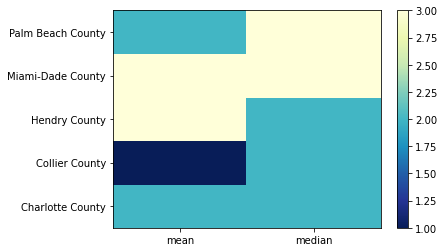

In [30]:
# Get threshold value for top 5% data that has highest median values.
top_25_median = df_weekly_stats["median"].quantile(.95)
# Get top 5% data that has highest median.
df_25_median = df_weekly_stats[df_weekly_stats["median"] >= top_25_median].sort_values(by = "median")
# Create subplot.
figure, h_map = plt.subplots(1,1)
# Plot heatmap.
cbar = h_map.pcolor(df_25_median.iloc[:,0:2], cmap='YlGnBu_r')
# Plot color bar.
figure.colorbar(cbar, ax = h_map)
# Set tick values.
x_axis = plt.yticks(np.arange(.5, len(df_25_median.index), 1), df_25_median.index)
y_axis = plt.xticks(np.arange(.5, len(df_25_median.iloc[:,0:2].columns), 1), df_25_median.iloc[:,0:2].columns)

#### From finding the top median values we can see that Palm Beach, Miami-Dade, Hendry, Collier, and Charlotte are top performers for covid deaths.

# Task 1.4 Plot daily trends (cases and deaths, new cases) of state and top 5 infected counties. Utilize aggregrate, normalized by population, and log normalized values. - (Highest Performer of States)

# Cases

In [31]:
df_fl_daily = state_daily_cases_normalized("FL")
df_fl_agg = df_fl_daily.sum(axis = 0)
display(df_fl_agg)

cases - 1/22/20       0.0
cases - 1/23/20       0.0
cases - 1/24/20       0.0
cases - 1/25/20       0.0
                    ...  
cases - 9/13/20    1154.0
cases - 9/14/20     733.0
cases - 9/15/20    1357.0
cases - 9/16/20    1059.0
Length: 239, dtype: float64

### Statewide Daily Cases normalized by population - cases per 100,000

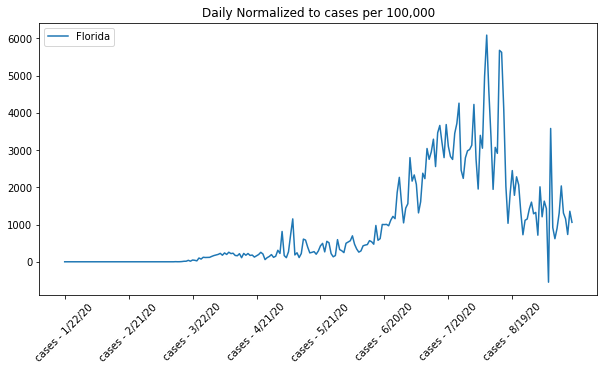

In [32]:
# Create subplot.
igure, axis = plt.subplots(1, figsize = (10,5))
# Plot daily normalized cases.
axis.plot(df_fl_agg, label = "Florida")
# Set xtick values.
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
# Set graph settings.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to cases per 100,000")
plt.show()

### Counties Daily Cases Normalized by Population - cases per 100,000

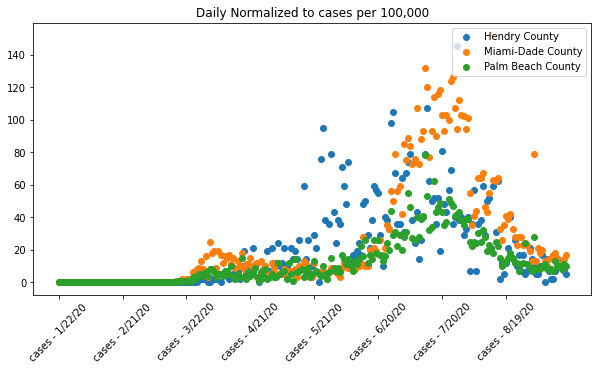

In [33]:
# Create subplot.
figure, axis = plt.subplots(1, figsize = (10,5))
# For each county.
for county in df_25_median[-3:].index.values:
    # Plot daily normalized cases.
    t = axis.scatter(df_fl_daily.loc[county].iloc[0].index,\
                    df_fl_daily.loc[county].iloc[0].values,\
                    label = county,
)
# Set xtick values.
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
# Set graph descriptors/options.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper right")
axis.title.set_text("Daily Normalized to cases per 100,000")
t = axis.plot()

### Ignoring errors from taking log

In [34]:
import warnings
warnings.simplefilter("ignore")

### County Daily Cases Normalized by population and log10 - cases per 100,000

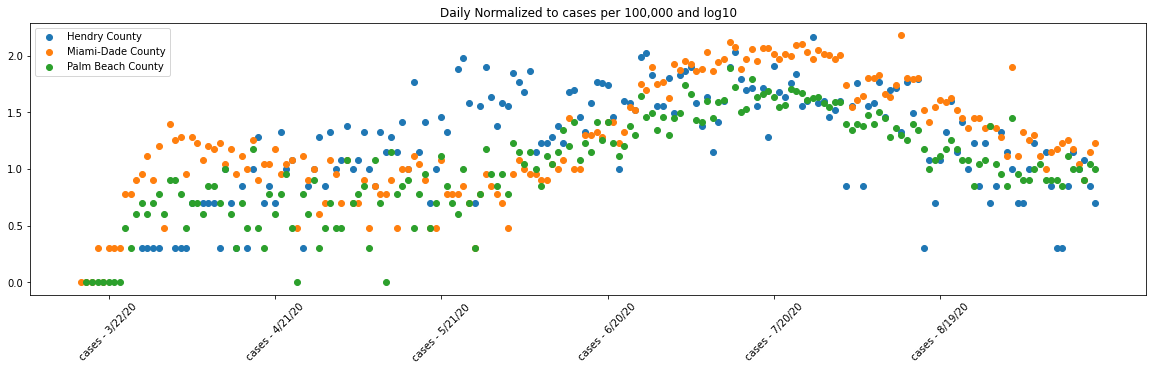

In [35]:
df_fl_daily = state_daily_cases_log10("FL")
# Create subplot.
figure, axis = plt.subplots(1, figsize = (20,5))
# For each county.
for county in df_25_median[-3:].index.values:
    # Plot daily normalized/log10 cases.
    t = axis.scatter(df_fl_daily.loc[county].iloc[0].index,\
                    df_fl_daily.loc[county].iloc[0].values,\
                    label = county)
# Set xtick values.
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
# Set graph descriptors/options.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to cases per 100,000 and log10")
t = axis.plot()

# Deaths

### Statewide Daily Deaths normalized by population - cases per 100,000

In [36]:
df_fl_daily = state_daily_deaths_normalized("FL")
df_fl_agg = df_fl_daily.sum(axis = 0)

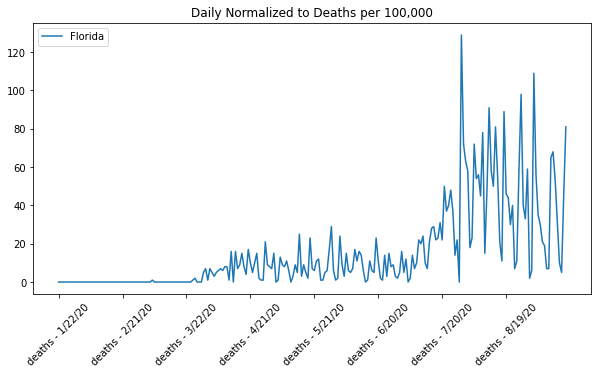

In [37]:
# Create subplot.
igure, axis = plt.subplots(1, figsize = (10,5))
# Plot daily normalized deaths.
axis.plot(df_fl_agg, label = "Florida")
# Set xtick values.
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
# Set graph descriptors/options.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to Deaths per 100,000")
plt.show()

### Counties Daily Deaths Normalized by Population - cases per 100,000

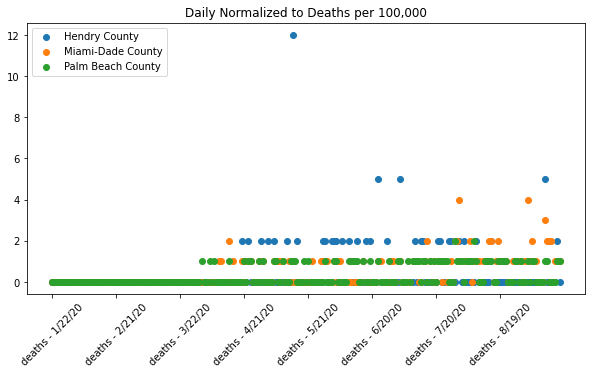

In [38]:
df_deaths_norm = state_daily_deaths_normalized("FL")
# Create subplot.
figure, axis = plt.subplots(1, figsize = (10,5))
# For each county.
for county in df_25_median[-3:].index.values:
    # Plot daily normalized deaths.
    t = axis.scatter(df_deaths_norm.loc[county].iloc[0].index,\
                    df_deaths_norm.loc[county].iloc[0].values,\
                    label = county,
)
# Set xtick values.
t = plt.xticks([col for col in df_deaths_norm.columns[0:-1:30]])
# Set graph descriptors/options.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to Deaths per 100,000")
t = axis.plot()

### County Daily Deaths Normalized by population and log10 - cases per 100,000

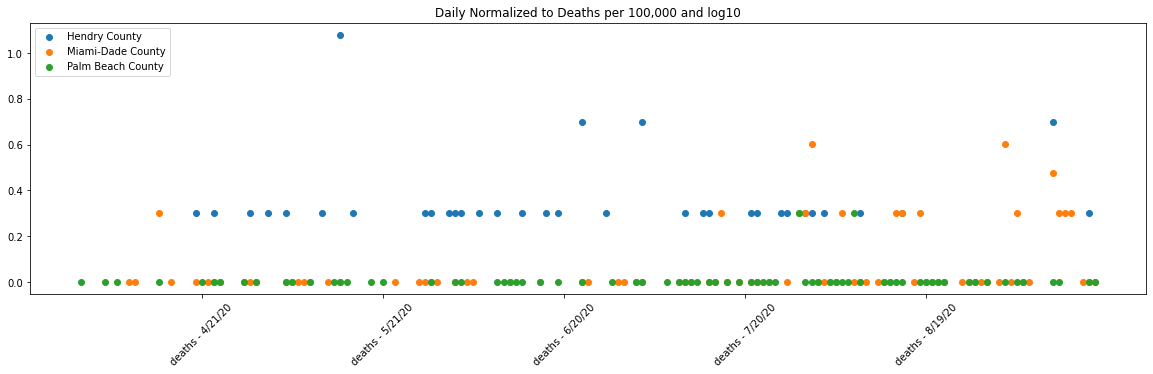

In [39]:
df_deaths_log = state_daily_deaths_log10("FL")
# Create subplot.
figure, axis = plt.subplots(1, figsize = (20,5))
# For each county.
for county in df_25_median[-3:].index.values:
    # Plot daily normalized/log10 deaths.
    t = axis.scatter(df_deaths_log.loc[county].iloc[0].index,\
                    df_deaths_log.loc[county].iloc[0].values,\
                    label = county)
# Set xtick values.
t = plt.xticks([col for col in df_deaths_log.columns[0:-1:30]])
# Set graph descriptors/options.
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to Deaths per 100,000 and log10")
t = axis.plot()